# Cluster tests
- This notebook serves a purpose of testing if the cluster simulation works.
- It is divided on four subsections:
    - section 1: helper code (contains various helper functions)
    - section 2: Static cluster - contains an experiment conducted on a static cluster
    - section 3: Basic HPA - cluster is being scaled with a basic HPA (we do not pay attention into maximum CPU usage
    - section 4: CPU-sensitive HPA - this time cluster is being scaled with a big smarter scaler, that pays attention into CPU usage 

## Section 1 - helper functions

In [ ]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from time import time, sleep

from cluster_simulator import SimpleCluster, Metric
from helper import dic2DF, plotClusterHistory

In [ ]:
def computeCost(df):
    tmp = df[df.totalDone < df.totalTasks.max()]
    working_cost = (tmp.dep1_pods + tmp.dep2_pods + tmp.dep3_pods).sum()
    total_cost = (df.dep1_pods + df.dep2_pods + df.dep3_pods).sum()
    return working_cost, total_cost

In [ ]:
def createCluster():
    """ Returns a cluster used in this notebook (all experiments)"""
    return SimpleCluster(
        durations = [1e3, 6e3, 2e3], 
        pods = [1, 4, 2])


TASKS = [4, 6, 2, 4, ] + [0 ]* 7 + [7, 12, 10, 21] + [0] * 3 + [11, 8, 13, 7] * 3
NR_STEPS = 100

### Cluster description
The cluster here is built of three deployments: Dep1, Dep2 and Dep3.
The tasks flow in series, from Dep1, to Dep3. The deployment descriptions are as follows:
- Deployment 1:
    - Number of pods: 1
    - Duration (how long the task is being processed): 1ms += 30%, (random.normal)
    - CPU consumption: 20 units per working pod +-30%, (random.normal), (+ 1 unit per pod even if it is not working
    - Memory consumption: 20 units per working pod +-30%, (random.normal), (+ 1 unit per pod even if it is not working
- Deployment 2:
    - Number of pods: 4
    - Duration (how long the task is being processed): 6ms += 30%, (random.normal)
    - CPU consumption: 20 units per working pod +-30%, (random.normal), (+ 1 unit per pod even if it is not working
    - Memory consumption: 20 units per working pod +-30%, (random.normal), (+ 1 unit per pod even if it is not working
- Deployment 3:
    - Number of pods: 2
    - Duration (how long the task is being processed): 2ms += 30%, (random.normal)
    - CPU consumption: 20 units per working pod +-30%, (random.normal), (+ 1 unit per pod even if it is not working
    - Memory consumption: 20 units per working pod +-30%, (random.normal), (+ 1 unit per pod even if it is not working



![Alt text](./images/ClusterScheme.jpg "Cluster Scheme")

## Section 2 - Static cluster

Here we can observe a cluster that does not change in time. The cluster is fed with tasks (requests) defined in `TASKS` variable (each value corresponds to the number of tasks / iteration). The tasks are pushed through the cluster from the first to the last deployment. 

The results are presented in the charts, with the meaning as follows:
- `pods` - total number of the active pods. This cluster is not scaled, so the values are static (1 pod for dep1, 4 pods for dep2 and 2 pods for dep3)
- `activePods` - the number of pods that are active (are working on a task)
- `queueTasks` - the number of tasks that are already sent to the deployment but cannot be run due to the lack of free pods (tasks in the queue)
- `cpu (total)` - total cluster cpu usage
- `cpu` - cpu usage per deployment
- `Number of tasks` - Total number of the tasks received and finished by the cluster. This is a counter
- `nrDone` - total number of finished tasks (by deployment). This is a counter.



In [ ]:
cluster = createCluster()
res = {}
res[0] = cluster.getMetrics()
#print (f'time: 0, {res[0]}')

start_time = time()
total_tasks = 0
for i in range(NR_STEPS):
    if i < len(TASKS):
        cluster.addTasks(TASKS[i], life_time = 1e6)
    cluster.update()    
    t = cluster.env.now
    metrics = cluster.getMetrics()
    #print (f'time: {t}, {metrics}')
    res[t] = metrics

df = dic2DF(res)
plotClusterHistory(df)
working_cost, total_cost = computeCost(df)
print (f'WORKING_COST: {working_cost}, TOTAL COST: {total_cost}')

#### Static Cluster Conclusions
This cluster could not finish all the given tasks within the defined time frame.  All the tasks were sent relatively quickly, so in the beginning Deployment 1 was a bottleneck. In time, the most time and CPU consumming work was conducted by deployment 2. One can also notice, that Deployment 3 was now fully loaded - quite often it has only one, or even zero active tasks. 

In summary: Such a cluster works, but clearly it can be optimized.

## Section 3 - Basic HPA

This time the cluster is controled by a simple set of rules implemented in `HPABasic` class. By controlling a cluster I mean increasing or decreasing a number of pods for each deployment. `HPABasic` class controls the number of pods based on two simple rules:
- if there are more than 5 tasks in the queue (not started), increase the number of pods for this deployment
- if there are no activePods (the deployment is not working on any task), reduce the number of pods. *Note - the number of pods can never be less than 1.*



In [ ]:
class HPABasic:
    def __init__(self):
        self.deploymentMetrics = []
        pass
    
    def processMetrics(self, metrics):
        self.deploymentMetrics = []
        metrics = metrics[2:]
        for m in metrics:
            self.deploymentMetrics.append(Metric(m))

        update_deployments = [0] * len(self.deploymentMetrics)
        for i, m in enumerate(self.deploymentMetrics):
            if m.queueTasks > 5:
                update_deployments[i] = 1
            elif m.activePods == 0:
                update_deployments[i] = -1

        return update_deployments
            
    

In [ ]:
cluster = createCluster()
res = {}
res[0] = cluster.getMetrics()
#print (f'time: 0, {res[0]}')
hpa = HPABasic()

start_time = time()

total_tasks = 0
for i in range(NR_STEPS):
    if i < len(TASKS):
        cluster.addTasks(TASKS[i], life_time = 1e6)
    cluster.update()    
    t = cluster.env.now
    metrics = cluster.getMetrics()
    #print (f'time: {t}, {metrics}')
    res[t] = metrics
    update_deployments = hpa.processMetrics(metrics)    
    cluster.updateDeployments(update_deployments)
    sleep(1e-3)

df = dic2DF(res)
plotClusterHistory(df)
working_cost, total_cost = computeCost(df)
print (f'WORKING_COST: {working_cost}, TOTAL COST: {total_cost}')

#### Section 3 conclusions
The scaling process worked as expected, the cluster managed to solve all the tasks within a given time frame. In fact, it went really fast - it required around 50 miliseconds to solve everything.

The largest bottleneck (in Deployment 2) was solved by significant increase in the number of pods for this deployment - in a peek, it went up from 4 to 17 deployments. 

The only problem with such an approach is the CPU usage, that is not restricted by any rules. This resulted with the maximum usage (in a peek) over 400 units, compared to 150 units in a peek for the previous experiment. 

## Section 4 - CPU sensitive HPA

This time the cluster is controled by a bit more advanced HPA, that pays attention not only to the number of tasks, but also to the total number of pods. The goal is to optimize the number of pods, and, simultaneously, keep the maximum number of pods within the certain limits (not more than 7 pods to keep it consistent with the first experiments). 
A set of rules implemented in `HPA1` class is based on two thresholds:
- pod_warning (here: 3)
- pod_max (here: 7)

and looks as follows:
- if the total number of pods exceeds pod_max, do not increase the number of pods
- otherwise, if there are more than 5 tasks in the queue (for any deployment):
    - if the total number of pods exceeds pod_warning, increase the number of pods only in the deployment with the largest number of the tasks in the queue
    - otherwise increase the number of pods fo each deployment with more than 5 tasks in the queue    
- if there are no activePods (the deployment is not working on any task), reduce the number of pods. *Note - the number of pods can never be less than 1.*


**Note: 700 CPU units corresponds to 7 pods from the first experiment**

In [ ]:
class HPA1:
    def __init__(self, pod_warning = 3, pod_max = 7):
        self.pod_warning = pod_warning
        self.pod_max = pod_max
        self.deploymentMetrics = []
        pass
    
    def processMetrics(self, metrics):
        self.deploymentMetrics = []
        metrics = metrics[2:]
        for m in metrics:
            self.deploymentMetrics.append(Metric(m))
            

        update_deployments = [0] * len(self.deploymentMetrics)
        nr_pods = sum([m.pods for m in self.deploymentMetrics])
        
        to_increase = -1
        queue_tasks_max = 0
        
        for i, m in enumerate(self.deploymentMetrics):
            if m.queueTasks > 5:
                if nr_pods < self.pod_warning:
                    update_deployments[i] = 1
                elif nr_pods < self.pod_max:
                    if m.queueTasks > queue_tasks_max:
                        queue_tasks_max = m.queueTasks
                        to_increase = i
            elif m.activePods == 0:
                update_deployments[i] = -1

        if to_increase >= 0:
            update_deployments[to_increase] = 1
                
        return update_deployments
            

In [ ]:
hpa = HPA1()
cluster = createCluster()
res = {}
res[0] = cluster.getMetrics()
#print (f'time: 0, {res[0]}')

start_time = time()
total_tasks = 0
for i in range(NR_STEPS):
    if i < len(TASKS):
        cluster.addTasks(TASKS[i], life_time = 1e6)
    cluster.update()    
    t = cluster.env.now
    metrics = cluster.getMetrics()
    #print (f'time: {t}, {metrics}')
    res[t] = metrics
    update_deployments = hpa.processMetrics(metrics)    
    cluster.updateDeployments(update_deployments)
    sleep(1e-3)

df = dic2DF(res)
plotClusterHistory(df)
working_cost, total_cost = computeCost(df)
print (f'WORKING_COST: {working_cost}, TOTAL COST: {total_cost}')

#### Section 4 - conclusions
In short - it worked. The cluster did not exceed the assumed CPU consumption, and managed to finish the tasks in time. I think it may be used even for a more complicated cluster. However, based on the `queueTasks` chart one can notice, that there is still a bottleneck in Deployment 2. Such bottleneck suggests that there is still a space for optimalization. This bottleneck can be solved by more advanced cluster controller, this is where we hope to employe Reinforecement Learning agents.

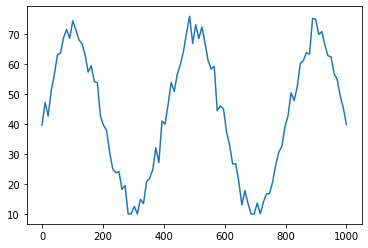